In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import datetime

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

In [3]:
target='transaction_real_price'

In [4]:
h2o.init() # start h2o

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_191"; Java(TM) SE Runtime Environment (build 1.8.0_191-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /Users/bonnie/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/f1/2lb7b2n57j9d7ktf62rd4mkh0000gn/T/tmpnu6hkoqm
  JVM stdout: /var/folders/f1/2lb7b2n57j9d7ktf62rd4mkh0000gn/T/tmpnu6hkoqm/h2o_bonnie_started_from_python.out
  JVM stderr: /var/folders/f1/2lb7b2n57j9d7ktf62rd4mkh0000gn/T/tmpnu6hkoqm/h2o_bonnie_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,"14 days, 20 hours and 13 minutes"
H2O cluster name:,H2O_from_python_bonnie_9b0rf3
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [5]:
df = h2o.import_file(path = 'data/trainPriceCleaned.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
df.describe()

Rows:4465
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,int,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,15150000.0,0.0,23.32,1.0,0.0,100.0,1.0,25.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,407325225.0839865,0.6326987681970885,78.98916750279955,10.478387458006718,1358.196640537514,1205.4591265397537,13.059350503919374,101.8436640537514,302.55341545352746,2.9393057110862264,1.5979843225083987,0.23829787234042554,0.7617021276595745,0.08421052631578947,0.23852183650615902,0.6772676371780515,0.26382978723404255,0.01702127659574468,0.7191489361702128
maxs,3878340000.0,1.0,244.8647,59.0,9766.0,6864.0,124.0,309.36,2960.0,6.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,316990725.1286814,0.48212352757671595,27.536207663209645,7.258355776752853,1511.328449626355,1147.2439103271977,14.478395659958464,32.50384704917918,342.17734963028045,0.6466331065494135,0.5029887953511339,0.4260899642891898,0.4260899642891898,0.27773438634871633,0.42622747160873403,0.4675736829724452,0.4407574610598276,0.12936499080697303,0.4494652253397927
zeros,0,1640,0,0,5,0,0,0,54,8,8,3401,1064,4089,3400,1441,3287,4389,1254
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,570000000.0,1.0,84.91,15.0,1391.0,1606.0,15.0,104.75,958.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1050000000.0,1.0,84.99,17.0,7876.0,5563.0,65.0,109.35,828.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,586050000.0,0.0,156.7997,13.0,857.0,390.0,4.0,198.7,154.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
X  = [name for name in df.columns if name != target]
print(X)

['city', 'exclusive_use_area', 'floor', 'total_parking_capacity_in_site', 'total_household_count_in_sites', 'apartment_building_count_in_sites', 'supply_area', 'total_household_count_of_area_type', 'room_count', 'bathroom_count', 'heat_fuel_cogeneration', 'heat_fuel_gas', 'heat_type_central', 'heat_type_district', 'heat_type_individual', 'front_door_structure_corridor', 'front_door_structure_mixed', 'front_door_structure_stairway']


In [8]:
# Set target and predictor variables
y = target
project = 'hyper'

In [9]:
def get_leaderBoard(runtime):
    aml = H2OAutoML(max_runtime_secs=runtime, 
                    project_name = project)
    aml.train(x=X, y=y, training_frame=df)
    
    board = aml.leaderboard    
    print ('get_leaderBoard done')
    return board

In [ ]:
def get_BestModel(board_csv):
    all_params = []
    for index, row in board_csv.iterrows():    
        model_list.append(row['model_id'])
    for i in model_list:  
        print (i)
        model = h2o.get_model(i)
        params = model.params        
        all_params.append(params)
    
    print ("get_all_params done")
    print ('model_list : ', len(model_list))
    print ('all_params : ', len(all_params))
    return all_params      

In [10]:
def board_to_csv(board, runtime):
    board_csv = board.as_data_frame() 
    system_date = datetime.date.today()
    board_csv['system_date'] = system_date
    board_csv['runtime'] = runtime
    print ('board_to_csv done')
    return board_csv    

In [63]:
def get_modelList(board_csv):
    model_list = []
    for index, row in board_csv.iterrows():    
        model_list.append(row['model_id'])
    return model_list

In [45]:
def get_all_params(board_csv):
    all_params = []
    model_list = get_modelList(board_csv)
    for i in model_list:  
        print (i)
        model = h2o.get_model(i)
        params = model.params        
        all_params.append(params)
    print ("get_all_params done")
    print ('model_list : ', len(model_list))
    print ('all_params : ', len(all_params))
    return all_params

In [48]:
def get_BestModel(board_csv):
    id = board_csv['model_id'][0]
    best_model = h2o.get_model(id)
    return best_model        

In [355]:
def get_all_varimp(board_csv):
    model_list = get_modelList(board_csv) 
    tup=[]
    gg = 1
    for mid in model_list:    
        model = h2o.get_model(mid)
        varimp = model.varimp()       
        print("tryyyyyyyyyyyyyyyy          ", gg)
        gg+= 1
        try:
            for var_item in varimp:
                vv = []
                vv.append(mid)  
                ass = []                     
                for tit in var_item:     
                    ass.append(tit)           
                item = vv + ass
                tup.append(item)   
                
            print('done')
        except:  
            print(mid)  
            print('pass')  
            pass
        continue

    new_varimp = pd.DataFrame(tup, columns = ['model_id',
                                'variable', 
                                'relative_importance', 
                                'scaled_importance',
                                'percentage'                                
                               ]) 
            
    return new_varimp

In [357]:
runtime = 20
leaderBoard = get_leaderBoard(runtime)

board_csv = board_to_csv(leaderBoard, runtime)
board_csv.to_csv('result/300/leaderboard.csv', sep='\t')

params =  get_all_params(board_csv)
with open('result/300/params.json', 'w') as f:
    json.dump(ee, f)
    
all_varimp = get_all_varimp(board_csv)   
all_varimp.to_csv('result/300/all_varimp.csv', sep='\t')

AutoML progress: |████████████████████████████████████████████████████████| 100%
get_leaderBoard done
board_to_csv done
GBM_1_AutoML_20190415_201144
XGBoost_1_AutoML_20190415_201144
XGBoost_1_AutoML_20190415_220045
XGBoost_1_AutoML_20190415_220145
GBM_grid_1_AutoML_20190415_201144_model_3
XGBoost_1_AutoML_20190416_013912
GBM_4_AutoML_20190415_201144
XGBoost_1_AutoML_20190415_195347
XGBoost_2_AutoML_20190415_201144
XRT_1_AutoML_20190415_201144
GBM_3_AutoML_20190415_201144
GBM_2_AutoML_20190415_201144
DRF_1_AutoML_20190415_201144
XGBoost_2_AutoML_20190415_220145
XGBoost_3_AutoML_20190415_201144
XGBoost_grid_1_AutoML_20190415_201144_model_1
XGBoost_2_AutoML_20190415_220045
XGBoost_2_AutoML_20190416_013912
GBM_grid_1_AutoML_20190415_201144_model_7
GBM_grid_1_AutoML_20190415_201144_model_8
GBM_grid_1_AutoML_20190415_201144_model_6
GBM_grid_1_AutoML_20190415_201144_model_11
GBM_grid_1_AutoML_20190415_201144_model_2
GBM_grid_1_AutoML_20190415_201144_model_5
GBM_5_AutoML_20190415_201144
GBM_gr

In [137]:
tup1 = (i,j,)
       # tup2 = (,)
        #tup3 = tup1 + tup2
        new = tup1
        
        new_varimp.append(new)
    print (new_varimp)



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 7)

In [ ]:
vamp_csv = pd.DataFrame(varimp, 
                            columns = ['variable', 
                                       'relative_importance',
                                       'scaled_importance',
                                       'percentage']) 
    vamp_csv['model_id']  = i
    result = frame.append(vamp_csv)

In [76]:
vamp_csv

,variable,relative_importance,scaled_importance,percentage,model_id
0,supply_area,1.746461e+20,1.000000,0.281362,GBM_grid_1_AutoML_20190415_201144_model_4
1,total_parking_capacity_in_site,7.106299e+19,0.406897,0.114485,GBM_grid_1_AutoML_20190415_201144_model_4
2,total_household_count_of_area_type,6.636811e+19,0.380015,0.106922,GBM_grid_1_AutoML_20190415_201144_model_4
3,floor,6.378004e+19,0.365196,0.102752,GBM_grid_1_AutoML_20190415_201144_model_4
4,apartment_building_count_in_sites,5.247006e+19,0.300436,0.084531,GBM_grid_1_AutoML_20190415_201144_model_4
5,exclusive_use_area,4.634108e+19,0.265343,0.074657,GBM_grid_1_AutoML_20190415_201144_model_4
6,total_household_count_in_sites,3.700841e+19,0.211905,0.059622,GBM_grid_1_AutoML_20190415_201144_model_4
7,heat_fuel_cogeneration,3.146001e+19,0.180136,0.050683,GBM_grid_1_AutoML_20190415_201144_model_4
8,room_count,2.171885e+19,0.124359,0.034990,GBM_grid_1_AutoML_20190415_201144_model_4
9,city,2.121044e+19,0.121448,0.034171,GBM_grid_1_AutoML_20190415_201144_model_4


In [ ]:
varimp = best_model.varimp()

In [ ]:
def get_varimp(board_csv):
    
    model_list = get_modelList(board_csv)
    
    
    for i in model_list:  
        print (i)
        model = h2o.get_model(i)
        varimp = model.varimp()
        
        
        vamp_csv = pd.DataFrame(varimp, 
                                columns = ['variable', 
                                           'relative_importance', 
                                           'scaled_importance',
                                           'percentage']) 
        vamp_csv['model_id'] = i
    print ('done')
      
        

In [49]:
best_model = get_BestModel(board_csv)

In [55]:
fg = best_model.varimp()
fg

[('supply_area', 5.355707768835502e+20, 1.0, 0.2828908289899341),
 ('city', 3.4799806901901066e+20, 0.6497704580596941, 0.18381410353367608),
 ('exclusive_use_area',
  2.3511374347003914e+20,
  0.4389965875997752,
  0.12418810858985264),
 ('apartment_building_count_in_sites',
  1.1646203962873138e+20,
  0.2174540595855809,
  0.06151575918339151),
 ('total_parking_capacity_in_site',
  1.1368426863669019e+20,
  0.21226749767455794,
  0.060048528384774605),
 ('room_count',
  8.192512155898505e+19,
  0.15296787109203705,
  0.04327320786205174),
 ('floor', 7.808684961172134e+19, 0.14580117695387226, 0.041245815816188997),
 ('total_household_count_in_sites',
  7.225703665111348e+19,
  0.13491594345675886,
  0.03816648308844159),
 ('heat_fuel_gas',
  6.984222324349416e+19,
  0.130407083915036,
  0.036890968074884435),
 ('heat_fuel_cogeneration',
  5.1422386418339545e+19,
  0.09601417522733952,
  0.02716152962484687),
 ('bathroom_count',
  5.025567703792039e+19,
  0.09383573414956421,
  0.0265

In [54]:
type(fg[0])

tuple

In [102]:
dfObj = pd.DataFrame(fg, columns = ['variable', 'relative_importance', 'scaled_importance','percentage']) 
dfObj

,variable,relative_importance,scaled_importance,percentage
0,supply_area,7.661354e+20,1.000000,0.278459
1,exclusive_use_area,5.134831e+20,0.670225,0.186630
2,city,4.754017e+20,0.620519,0.172789
3,apartment_building_count_in_sites,1.845275e+20,0.240855,0.067068
4,total_parking_capacity_in_site,1.584386e+20,0.206802,0.057586
5,total_household_count_in_sites,1.223583e+20,0.159708,0.044472
6,total_household_count_of_area_type,9.606162e+19,0.125385,0.034914
7,floor,9.330845e+19,0.121791,0.033914
8,heat_type_individual,7.657353e+19,0.099948,0.027831
9,heat_fuel_gas,5.298236e+19,0.069155,0.019257


In [104]:
model_id = best_model.model_id
dfObj['model_id'] = model_id
dfObj

,variable,relative_importance,scaled_importance,percentage,model_id
0,supply_area,7.661354e+20,1.000000,0.278459,XGBoost_1_AutoML_20190415_124010
1,exclusive_use_area,5.134831e+20,0.670225,0.186630,XGBoost_1_AutoML_20190415_124010
2,city,4.754017e+20,0.620519,0.172789,XGBoost_1_AutoML_20190415_124010
3,apartment_building_count_in_sites,1.845275e+20,0.240855,0.067068,XGBoost_1_AutoML_20190415_124010
4,total_parking_capacity_in_site,1.584386e+20,0.206802,0.057586,XGBoost_1_AutoML_20190415_124010
5,total_household_count_in_sites,1.223583e+20,0.159708,0.044472,XGBoost_1_AutoML_20190415_124010
6,total_household_count_of_area_type,9.606162e+19,0.125385,0.034914,XGBoost_1_AutoML_20190415_124010
7,floor,9.330845e+19,0.121791,0.033914,XGBoost_1_AutoML_20190415_124010
8,heat_type_individual,7.657353e+19,0.099948,0.027831,XGBoost_1_AutoML_20190415_124010
9,heat_fuel_gas,5.298236e+19,0.069155,0.019257,XGBoost_1_AutoML_20190415_124010


In [58]:
model_list = get_modelList(board_csv)

for i in model_list:  
    print (i)
    
    model = h2o.get_model(i)
    varimp = model.varimp()
    vamp_csv = pd.DataFrame(varimp, 
                                columns = ['variable', 
                                           'relative_importance', 
                                           'scaled_importance',
                                           'percentage']) 
    vamp_csv['model_id'] = i
    print ('done')

TypeError: 'NoneType' object is not iterable

In [61]:
model_list = get_modelList(board_csv)
print(model_list)

None


In [105]:
params = best_model.params
params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XGBoost_1_AutoML_20190415_124010',
   'type': 'Key<Model>',
   'URL': '/3/Models/XGBoost_1_AutoML_20190415_124010'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_trainPriceCleaned.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_trainPriceCleaned.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'

In [13]:
params = best_model.params
params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XGBoost_1_AutoML_20190415_124010',
   'type': 'Key<Model>',
   'URL': '/3/Models/XGBoost_1_AutoML_20190415_124010'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_trainPriceCleaned.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_trainPriceCleaned.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'

In [14]:
gg = h2o.get_model(aml.leaderboard[2,'model_id'])
gg

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190415_124010


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 8277652039089038.0
RMSE: 90981602.7507157
MAE: 58442347.67480403
RMSLE: 0.21739540785820188
Mean Residual Deviance: 8277652039089038.0

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 2.597665337554727e+16
RMSE: 161172743.89780447
MAE: 95202015.22597985
RMSLE: 0.32580066367998356
Mean Residual Deviance: 2.597665337554727e+16
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,95202016.0000000,3471115.2,100623912.0000000,91163912.0000000,98595584.0000000,87721416.0000000,97905256.0000000
mean_residual_deviance,25976653700000000.0000000,4189882330000000.0000000,26296592300000000.0000000,20727619500000000.0000000,33349843400000000.0000000,18026095900000000.0000000,31483117400000000.0000000
mse,25976653700000000.0000000,4189882330000000.0000000,26296592300000000.0000000,20727619500000000.0000000,33349843400000000.0000000,18026095900000000.0000000,31483117400000000.0000000
r2,0.7435545,0.0224293,0.7614703,0.7397454,0.7141171,0.7942962,0.7081433
residual_deviance,25976653700000000.0000000,4189882330000000.0000000,26296592300000000.0000000,20727619500000000.0000000,33349843400000000.0000000,18026095900000000.0000000,31483117400000000.0000000
rmse,160089728.0000000,13189609.0000000,162162240.0000000,143970896.0000000,182619392.0000000,134261296.0000000,177434816.0000000
rmsle,0.3256595,0.0067798,0.3382431,0.3203479,0.3308964,0.3102552,0.3285551


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-15 12:40:29,18.392 sec,0.0,516114768.6270046,407325224.7237402,266374454394906464.0000000
,2019-04-15 12:40:29,18.448 sec,5.0,418608767.0014673,318561097.3442329,175233299810488704.0000000
,2019-04-15 12:40:29,18.493 sec,10.0,341576112.6332141,249194663.2886898,116674240721618144.0000000
,2019-04-15 12:40:29,18.542 sec,15.0,283318044.6351890,196248365.6940649,80269114415906928.0000000
,2019-04-15 12:40:29,18.602 sec,20.0,239530744.4666728,157008276.5334826,57374977544758496.0000000
---,---,---,---,---,---,---
,2019-04-15 12:40:31,20.573 sec,120.0,93456366.1883762,59601432.2526316,8734092381135866.0000000
,2019-04-15 12:40:31,20.696 sec,125.0,92610717.4942993,59199813.3903695,8576744994808916.0000000
,2019-04-15 12:40:31,20.833 sec,130.0,91920919.8635470,58852808.0125420,8449455508560628.0000000
,2019-04-15 12:40:31,20.958 sec,135.0,91186238.9842962,58508396.8179171,8314930180101174.0000000



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
supply_area,766135409740921962496.0000000,1.0,0.2784589
exclusive_use_area,513483118801716248576.0000000,0.6702250,0.1866301
city,475401735883833999360.0000000,0.6205192,0.1727891
apartment_building_count_in_sites,184527482868065107968.0000000,0.2408549,0.0670682
total_parking_capacity_in_site,158438605215731023872.0000000,0.2068024,0.0575860
total_household_count_in_sites,122358280683842961408.0000000,0.1597084,0.0444722
total_household_count_of_area_type,96061621722138279936.0000000,0.1253847,0.0349145
floor,93308453402280198144.0000000,0.1217911,0.0339138
heat_type_individual,76573525787715567616.0000000,0.0999478,0.0278313
heat_fuel_gas,52982364719735111680.0000000,0.0691554,0.0192569


In [15]:
params = gg.params
print (params)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_1_AutoML_20190415_124010', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_1_AutoML_20190415_124010'}}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'automl_training_trainPriceCleaned.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/automl_training_trainPriceCleaned.hex'}}, 'validation_frame': {'default': None, 'actual': None}, 'nfolds': {'default': 0, 'actual': 5}, 'keep_cross_validation_models': {'default': True, 'actual': False}, 'keep_cross_validation_predictions': {'default': False, 'actual': True}, 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False}, 'score_each_iteration': {'default': False, 'actual': False}, 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'}, 'fold_column': {'default': None, 'actual': 

In [1]:
print (params)

NameError: name 'params' is not defined

In [33]:
gg = [aml.leaderboard[2,'model_id']]
with open('800_data.json', 'w') as f:
    json.dump(gg, f)
print ("done")

TypeError: Object of type H2OFrame is not JSON serializable

In [15]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [ ]:
params = best_model.params
print (params)
with open('800_data.json', 'w') as f:
    json.dump(params, f)
print ("done")

In [16]:
best_model.algo

'xgboost'

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

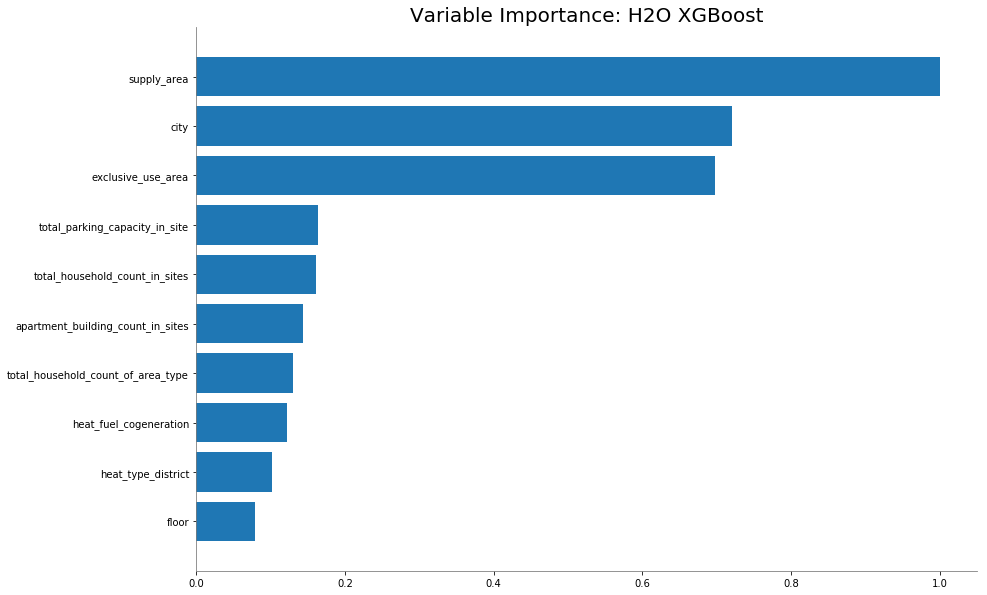

In [18]:
best_model.varimp_plot()

In [19]:
df[y] = df[y].asfactor()

In [20]:
df.describe()

Rows:4447
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,enum,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,,0.0,24.2475,1.0,0.0,100.0,1.0,33.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,,0.633235889363616,80.43324200584667,10.161457162131775,1320.9788621542616,1191.7533168428156,12.970991679784124,103.30118956599955,292.6532493816056,2.9759388351697784,1.597031706768608,0.2397121655048347,0.7602878344951652,0.08162806386327862,0.24061164830222623,0.6777602878344952,0.259051045648752,0.016865302451090622,0.7240836519001574
maxs,,1.0,266.8181,66.0,9766.0,6864.0,124.0,343.89,2960.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,,0.4819755547191596,28.772107257421734,7.028892141141552,1448.080749614069,1135.12591706417,14.331711124397955,33.90022505192435,329.45238690672653,0.6674127834544982,0.5081169355394869,0.4269557765991174,0.4269557765991174,0.27382801949303126,0.427502959168945,0.46738678111809034,0.43816295324580384,0.12878118423684082,0.4470251147192063
zeros,,1631,0,0,3,0,0,0,54,8,8,3381,1066,4084,3377,1433,3295,4372,1227
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,334000000,1.0,84.94,12.0,3481.0,2678.0,25.0,102.02,2254.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,400000000,1.0,114.88,17.0,1665.0,2017.0,22.0,137.59,325.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,290000000,0.0,84.96,7.0,1761.0,1326.0,9.0,109.77,209.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
# set auto

aml = H2OAutoML(max_runtime_secs=900, exclude_algos = ['DeepLearning'])

model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)
    
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}
print (meta_data)

print(aml.leaderboard)

AutoML progress: |████████████████████████████████████████████████████████| 100%
{'model_execution_time': {'regression': 770.712281703949}}


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_1_AutoML_20190412_025147,2.83413e+16,1.68349e+08,2.83413e+16,1.02997e+08,0.336906
XGBoost_grid_1_AutoML_20190412_025147_model_1,2.84504e+16,1.68672e+08,2.84504e+16,1.00677e+08,0.32952
GBM_1_AutoML_20190412_030307,2.85147e+16,1.68863e+08,2.85147e+16,1.02924e+08,0.338887
XGBoost_grid_1_AutoML_20190412_025147_model_9,2.92906e+16,1.71145e+08,2.92906e+16,1.01065e+08,0.332222
XGBoost_grid_1_AutoML_20190412_030307_model_9,2.94858e+16,1.71714e+08,2.94858e+16,1.01579e+08,0.333928
XGBoost_grid_1_AutoML_20190412_030307_model_4,2.96623e+16,1.72228e+08,2.96623e+16,1.027e+08,0.339225
GBM_grid_1_AutoML_20190412_030307_model_16,2.97983e+16,1.72622e+08,2.97983e+16,1.0639e+08,0.351746
XGBoost_grid_1_AutoML_20190412_025147_model_11,2.99557e+16,1.73077e+08,2.99557e+16,1.0138e+08,0.333319
GBM_grid_1_AutoML_20190412_025147_model_30,3.00097e+16,1.73233e+08,3.00097e+16,1.05518e+08,0.34497
XGBoost_1_AutoML_20190412_025147,3.00426e+16,1.73328e+08,3.00426e+16,1.02117e+08,0.332696


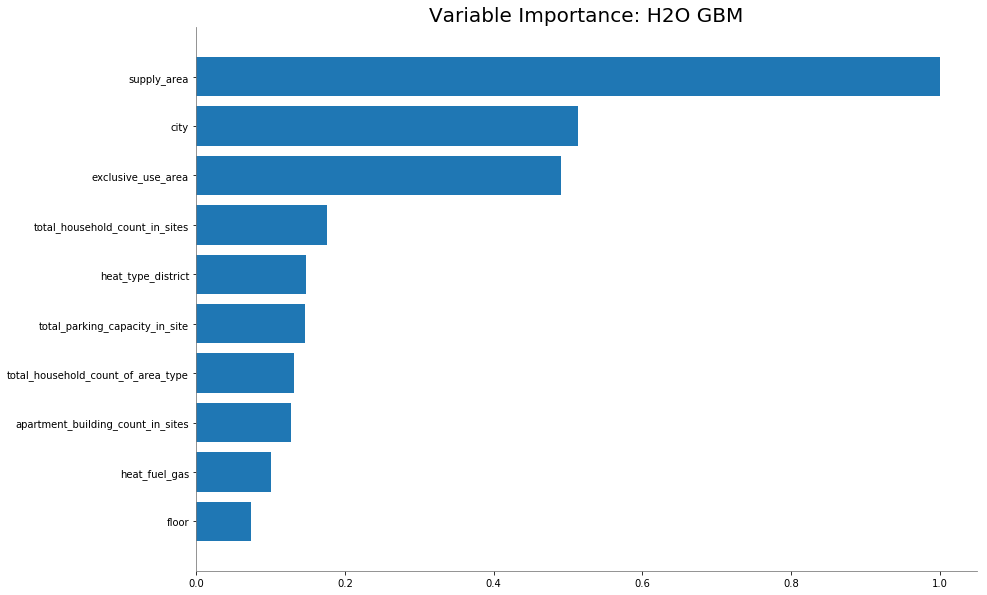

In [15]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

best_model.varimp_plot()

In [16]:
params = best_model.params
print (params)
with open('800_data.json', 'w') as f:
    json.dump(params, f)
print ("done")

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_20190412_030307', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_20190412_030307'}}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'automl_training_trainPriceCleaned.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/automl_training_trainPriceCleaned.hex'}}, 'validation_frame': {'default': None, 'actual': None}, 'nfolds': {'default': 0, 'actual': 5}, 'keep_cross_validation_models': {'default': True, 'actual': False}, 'keep_cross_validation_predictions': {'default': False, 'actual': True}, 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False}, 'score_each_iteration': {'default': False, 'actual': False}, 'score_tree_interval': {'default': 0, 'actual': 5}, 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},

In [11]:
aml = H2OAutoML(max_runtime_secs=700,
                exclude_algos = ['DeepLearning'])

model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [12]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}
meta_data

{'model_execution_time': {'regression': 647.3190739154816}}

In [13]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_1_AutoML_20190412_025147,2.83413e+16,1.68349e+08,2.83413e+16,1.02997e+08,0.336906
XGBoost_grid_1_AutoML_20190412_025147_model_1,2.84504e+16,1.68672e+08,2.84504e+16,1.00677e+08,0.32952
XGBoost_grid_1_AutoML_20190412_025147_model_9,2.92906e+16,1.71145e+08,2.92906e+16,1.01065e+08,0.332222
XGBoost_grid_1_AutoML_20190412_025147_model_11,2.99557e+16,1.73077e+08,2.99557e+16,1.0138e+08,0.333319
GBM_grid_1_AutoML_20190412_025147_model_30,3.00097e+16,1.73233e+08,3.00097e+16,1.05518e+08,0.34497
XGBoost_1_AutoML_20190412_025147,3.00426e+16,1.73328e+08,3.00426e+16,1.02117e+08,0.332696
XGBoost_grid_1_AutoML_20190412_025147_model_7,3.00548e+16,1.73363e+08,3.00548e+16,1.03362e+08,0.338225
XGBoost_grid_1_AutoML_20190412_025147_model_5,3.024e+16,1.73896e+08,3.024e+16,1.021e+08,0.337123
GBM_grid_1_AutoML_20190412_025147_model_7,3.04094e+16,1.74383e+08,3.04094e+16,1.03236e+08,0.342389
XGBoost_grid_1_AutoML_20190412_025147_model_13,3.05504e+16,1.74787e+08,3.05504e+16,1.02342e+08,0.333941


In [18]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [19]:
best_model.algo

'xgboost'

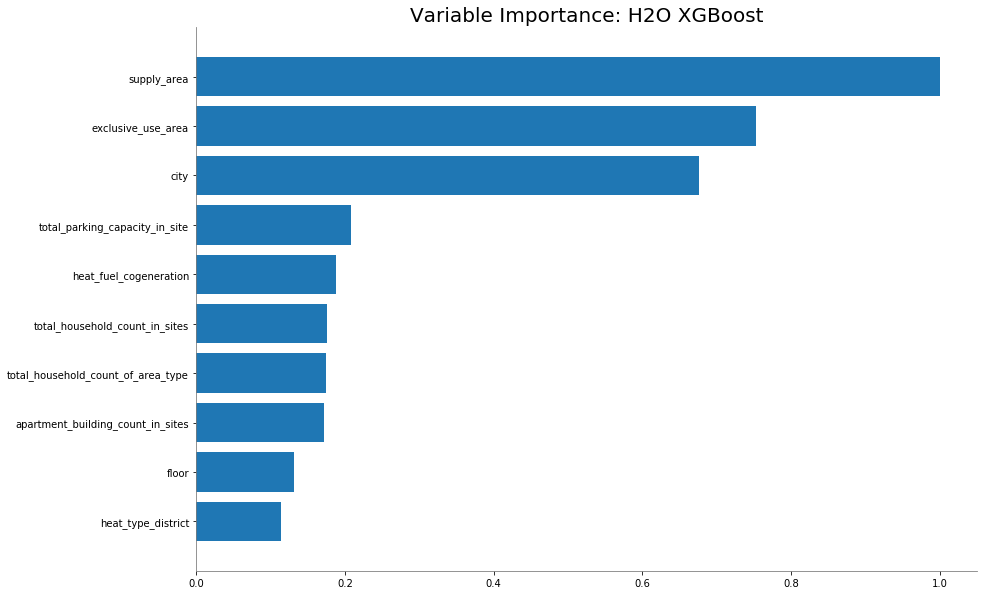

In [21]:
best_model.varimp_plot()

In [26]:
keys = best_model.params.keys()
keys

dict_keys(['model_id', 'training_frame', 'validation_frame', 'nfolds', 'keep_cross_validation_models', 'keep_cross_validation_predictions', 'keep_cross_validation_fold_assignment', 'score_each_iteration', 'fold_assignment', 'fold_column', 'response_column', 'ignored_columns', 'ignore_const_cols', 'offset_column', 'weights_column', 'stopping_rounds', 'stopping_metric', 'stopping_tolerance', 'max_runtime_secs', 'seed', 'distribution', 'tweedie_power', 'categorical_encoding', 'quiet_mode', 'export_checkpoints_dir', 'ntrees', 'max_depth', 'min_rows', 'min_child_weight', 'learn_rate', 'eta', 'sample_rate', 'subsample', 'col_sample_rate', 'colsample_bylevel', 'col_sample_rate_per_tree', 'colsample_bytree', 'max_abs_leafnode_pred', 'max_delta_step', 'monotone_constraints', 'score_tree_interval', 'min_split_improvement', 'gamma', 'nthread', 'max_bins', 'max_leaves', 'min_sum_hessian_in_leaf', 'min_data_in_leaf', 'sample_type', 'normalize_type', 'rate_drop', 'one_drop', 'skip_drop', 'tree_metho

In [37]:
params = best_model.params
params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XGBoost_grid_1_AutoML_20190412_012604_model_2',
   'type': 'Key<Model>',
   'URL': '/3/Models/XGBoost_grid_1_AutoML_20190412_012604_model_2'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_trainPriceCleaned.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_trainPriceCleaned.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'fold_assignment': {'default': 

In [38]:
with open('data.json', 'w') as f:
    json.dump(params, f)

In [22]:
df[y] = df[y].asfactor()

In [23]:
df.describe()

Rows:4447
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,enum,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,,0.0,24.2475,1.0,0.0,100.0,1.0,33.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,,0.633235889363616,80.43324200584667,10.161457162131775,1320.9788621542616,1191.7533168428156,12.970991679784124,103.30118956599955,292.6532493816056,2.9759388351697784,1.597031706768608,0.2397121655048347,0.7602878344951652,0.08162806386327862,0.24061164830222623,0.6777602878344952,0.259051045648752,0.016865302451090622,0.7240836519001574
maxs,,1.0,266.8181,66.0,9766.0,6864.0,124.0,343.89,2960.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,,0.4819755547191596,28.772107257421734,7.028892141141552,1448.080749614069,1135.12591706417,14.331711124397955,33.90022505192435,329.45238690672653,0.6674127834544982,0.5081169355394869,0.4269557765991174,0.4269557765991174,0.27382801949303126,0.427502959168945,0.46738678111809034,0.43816295324580384,0.12878118423684082,0.4470251147192063
zeros,,1631,0,0,3,0,0,0,54,8,8,3381,1066,4084,3377,1433,3295,4372,1227
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,334000000,1.0,84.94,12.0,3481.0,2678.0,25.0,102.02,2254.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,400000000,1.0,114.88,17.0,1665.0,2017.0,22.0,137.59,325.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,290000000,0.0,84.96,7.0,1761.0,1326.0,9.0,109.77,209.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [56]:
aml_1000 = H2OAutoML(max_runtime_secs=333,project_name = "project") # init automl, run for 300 seconds
aml_1000.train(x=X,  
           y=y,
           training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [57]:
leaderboard_1000 = aml_1000.leaderboard
leaderboard_1000.head(50)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190412_011235_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190412_005611_model_1,nan,nan,nan,nan


In [58]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=400,exclude_algos = ['DeepLearning'])

In [59]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [60]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

In [61]:
meta_data

{'model_execution_time': {'regression': 354.5295760631561}}

In [62]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190411_180444_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_203300_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_211049_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190412_004249_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190412_011844_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_192454_model_1,nan,nan,nan,nan


In [21]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time)

In [22]:
model_start_time = time.time()
  
try:
    aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
    logging.critical('aml.train') 
    h2o.download_all_logs(dirname=logs_path, filename=logfile)      
    h2o.cluster().shutdown()   
    sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [26]:
d=meta_data['model_execution_time']
d['classification']=(time.time() - model_start_time)
meta_data['model_execution_time'] = d

In [27]:
meta_data

{'model_execution_time': {'regression': 303.90435099601746,
  'classification': 870.9414427280426}}

In [28]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190411_180444_model_1,nan,nan,nan,nan


In [41]:
target='transaction_real_price'
min_mem_size=6
run_time=333

In [42]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [43]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [44]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

In [45]:
meta_data

{'model_execution_time': {'regression': 298.1435778141022}}

In [46]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190411_180444_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_203300_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_211049_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_192454_model_1,nan,nan,nan,nan


In [15]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [16]:
best_model.algo

'xgboost'

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

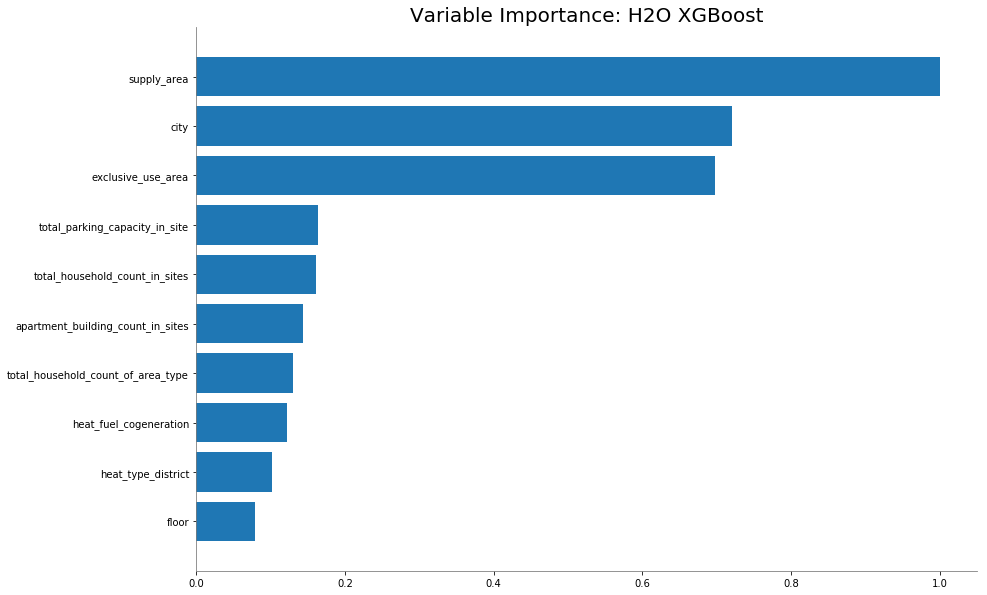

In [18]:
best_model.varimp_plot()

In [19]:
df[y] = df[y].asfactor()

In [20]:
df.describe()

Rows:4447
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,enum,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,,0.0,24.2475,1.0,0.0,100.0,1.0,33.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,,0.633235889363616,80.43324200584667,10.161457162131775,1320.9788621542616,1191.7533168428156,12.970991679784124,103.30118956599955,292.6532493816056,2.9759388351697784,1.597031706768608,0.2397121655048347,0.7602878344951652,0.08162806386327862,0.24061164830222623,0.6777602878344952,0.259051045648752,0.016865302451090622,0.7240836519001574
maxs,,1.0,266.8181,66.0,9766.0,6864.0,124.0,343.89,2960.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,,0.4819755547191596,28.772107257421734,7.028892141141552,1448.080749614069,1135.12591706417,14.331711124397955,33.90022505192435,329.45238690672653,0.6674127834544982,0.5081169355394869,0.4269557765991174,0.4269557765991174,0.27382801949303126,0.427502959168945,0.46738678111809034,0.43816295324580384,0.12878118423684082,0.4470251147192063
zeros,,1631,0,0,3,0,0,0,54,8,8,3381,1066,4084,3377,1433,3295,4372,1227
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,334000000,1.0,84.94,12.0,3481.0,2678.0,25.0,102.02,2254.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,400000000,1.0,114.88,17.0,1665.0,2017.0,22.0,137.59,325.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,290000000,0.0,84.96,7.0,1761.0,1326.0,9.0,109.77,209.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

meta_data

print(aml.leaderboard)

best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

best_model.algo

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

best_model.varimp_plot()

df[y] = df[y].asfactor()

df.describe()